# Causal Failures in Networks

The program is to solve optimization problems related to causal failures in networks.

# Functions

Import packages

In [1]:
import networkx as nx

Edges between two node sets, i.e. E(L, M)

In [2]:
def edge_between_set(G, L, M):
    """
    Count edges (u, v) that in E(G) ensuring u \in L and v \in M
    L and M are disjoint
    """
    all_edges = list(nx.edges(G))
    edges = []
    for node_1 in L:
        for node_2 in M:
            if tuple(sorted((node_1, node_2))) in all_edges and sorted((node_1, node_2)) not in edges:
                edges.append(sorted((node_1, node_2)))

    return len(edges)

Nodes between two node sets, i.e. T(L, M)

In [3]:
def node_between_set(G, L, M):
    """
    Count nodes v in V such that (u_1, v) and (u_2, v) are in E where u_1 in L and u_2 in M 
    """
    all_nodes = list(nx.nodes(G))
    all_edges = list(nx.edges(G))
    
    # T(L, M)
    nodes = []
    for v in all_nodes:
        for u_1 in L:
            for u_2 in M:
                if tuple(sorted((u_1, v))) in all_edges and tuple(sorted((u_2, v))) in all_edges:
                    nodes.append(v)
    
    return len(nodes)

Causality class

In [4]:
class Causality:
    def __init__(self, G, V_1, V_2):
        """
        G is the graph: a graph class generated by networkx
        V_1 is the node set whose removal causes failures of V_2
        both sets are represented as list of nodes
        
        """
        self.G = G
        self.V_1 = V_1
        self.V_2 = V_2
    
    def all_node(self, V_1, V_2):
        """
        All nodes to be removed
        """
        
        return list(set(V_1).union(set(V_2)))
    
    def kai(self, G, V_1, V_2):
        """
        The metric based on node degrees is defined as kai(C) where C is the causality.
        """
        
        # degree of V_1
        deg_V_1 = sum([d for n, d in G.degree(V_1)])
        
        # degree of V_2
        deg_V_2 = sum([d for n, d in G.degree(V_2)])
        
        return deg_V_1 + deg_V_2 + len(V_1) + len(V_2)- 2*edge_between_set(G, V_1, V_2)\
    - 2*edge_between_set(G, V_1, V_1) - 2*edge_between_set(G, V_2, V_2) - 2*node_between_set(G, V_1, V_2)

Algorithm_1: Find Maximal Set

In [5]:
def find_maximal_set(G, r, C):
    """
    G is the graph;
    r is the constant determing the size of giant component;
    C is the causality set, a list of causalities.
    This function is used to find the maximal causalities that a graph can apply
    """
    
    # preprocess causalities (property Union)
    p = 0
    while p < len(C) - 1:
        q = p + 1
        while q < len(C):
            if C[p].V_1 == C[q].V_1:
                C[p].V_2 = list(set(C[p].V_2).union(set(C[q].V_2)))
                C = C.remove(C[q])
            else:
                q += 1
        p += 1
    
    # computer kai value for each causality
    kai_dict = {}
    for causality in C:
        kai_dict[causality] = causality.kai(G, causality.V_1, causality.V_2)
    
    # sort causalities based on their kai values  
    sorted_dict = {key: value for key, value in sorted(kai_dict.items(), key=lambda item: item[1])}
    C = list(sorted_dict.keys())
    
    # the size of the initial largest giant component
    s = len(list(nx.nodes(G)))
    requirement = r*s
    
    # the index of causalities to be applied
    i = 0
    
    # maximal set of causalities
    mc = []
    
    # do hilw the size of the largest giant component meets the requirement
    while s > requirement:
        # add causality to mc
        if i > 0:
            mc.append(C[i - 1])
        
        # whether all causalities are applied
        if i > len(C) - 1:
            break
        
        # remove nodes and adjacent edges for causality C[i]
        remove_node = C[i].all_node(C[i].V_1, C[i].V_2)
        print(list(nx.nodes(G)))
        for v in remove_node:
            G.remove_node(v)
        s = len(max(nx.connected_components(G), key=len))
        i += 1
    
    # return maximal causality set
    return mc

# Example

In [6]:
def main():
    G = nx.Graph()
    
    # Topology construction
    G.add_edges_from([(1, 2), (1, 3), (1, 5), (2, 5), (3, 5), (4, 5), (4, 7), (4, 11), (5, 6), (5, 8), (5, 9), (6, 9),
                 (6, 10), (6, 12), (7, 11), (8, 9), (8, 14), (9, 12), (10, 12), (11, 13), (11, 15), (12, 14), 
                  (13, 14), (13, 15), (14, 16), (15, 16)])
    
    # Visualization
    nx.draw(G)
    
    # Causality
    C = []
    C_1 = Causality(G, [1, 4], [9, 12])
    C.append(C_1)
    C_2 = Causality(G, [5], [11, 16])
    C.append(C_2)
    C_3 = Causality(G, [3], [7])
    C.append(C_3)
    
    # Maximal set
    mc = find_maximal_set(G, 0.5, C)
    
    return mc

[1, 2, 3, 5, 4, 7, 11, 6, 8, 9, 10, 12, 14, 13, 15, 16]
[1, 2, 5, 4, 11, 6, 8, 9, 10, 12, 14, 13, 15, 16]
[2, 5, 11, 6, 8, 10, 14, 13, 15, 16]
Causality 1:[3],[7]
Causality 2:[1, 4],[9, 12]


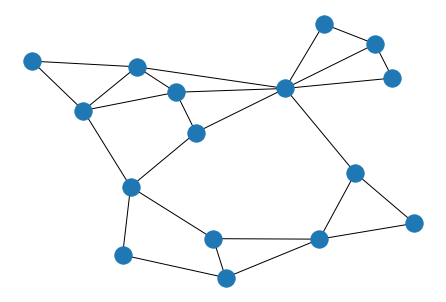

In [7]:
if __name__ == '__main__':
    mc = main()
    for i in range(len(mc)):
        print("Causality " + str(i+1) + ":" + str(mc[i].V_1) + "," + str(mc[i].V_2))